In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib.colors import CenteredNorm
from scipy import stats, signal
from cartopy import crs as ccrs, feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

## Get data from NOAA database and save it localy into NCDF file for faster computations

## Open saved NCDF

In [2]:
sst = xr.open_dataset('/home/jovyan/ohw24_proj_north_atlantic_variability_us/contributor_folders/Tanya_Popova/sst.nc')
sst

<xarray.Dataset> Size: 131MB
Dimensions:  (lat: 89, lon: 180, time: 2047)
Coordinates:
  * lat      (lat) float32 356B 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 720B -180.0 -178.0 -176.0 ... 174.0 176.0 178.0
  * time     (time) datetime64[ns] 16kB 1854-01-01 1854-02-01 ... 2024-07-01
Data variables:
    sst      (time, lat, lon) float32 131MB ...

In [7]:
sst_slice

<xarray.Dataset> Size: 21MB
Dimensions:  (lat: 45, time: 2047, lon: 56)
Coordinates:
  * lat      (lat) float32 180B 88.0 86.0 84.0 82.0 80.0 ... 8.0 6.0 4.0 2.0 0.0
  * time     (time) datetime64[ns] 16kB 1854-01-01 1854-02-01 ... 2024-07-01
  * lon      (lon) float32 224B -98.0 -96.0 -94.0 -92.0 ... 6.0 8.0 10.0 12.0
Data variables:
    sst      (time, lat, lon) float32 21MB ...

In [8]:
sst.coords['lon'] = (sst.coords['lon'] + 180) % 360 - 180
sst = sst.sortby(sst.lon)
sst_slice = sst.sel(lat=slice(90,0), lon=slice(-99,13))

# Define encoding with consistent fill values
encoding = {
    'sst': {
        '_FillValue': np.nan,  # or a specific value like -9999
        'missing_value': np.nan,  # should be the same as _FillValue
    }
}


sst_slice.to_netcdf('/home/jovyan/ohw24_proj_north_atlantic_variability_us/contributor_folders/Tanya_Popova/sst_north_atlantic.nc', encoding=encoding)

## Examplt plot for 1 timestamp

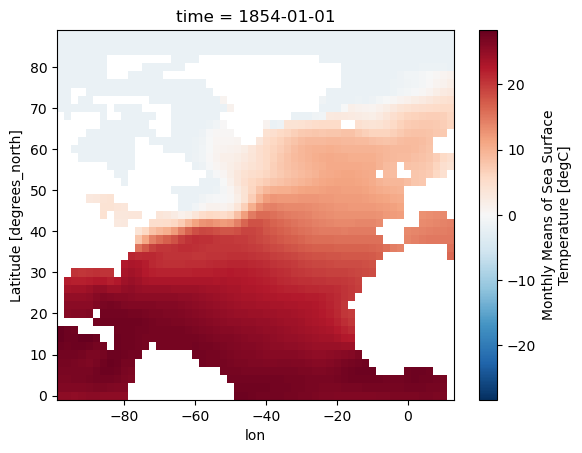

In [7]:
sst_slice.isel(time=0).plot()

## Spliting up on seasonal subsets and average. Winter - DJF, Summer - JJA

In [9]:
# open sst_north_atlantic
sst_slice = xr.open_dataset('/home/jovyan/ohw24_proj_north_atlantic_variability_us/contributor_folders/Tanya_Popova/sst_north_atlantic.nc')
sst_slice

<xarray.Dataset> Size: 21MB
Dimensions:  (lat: 45, time: 2047, lon: 56)
Coordinates:
  * lat      (lat) float32 180B 88.0 86.0 84.0 82.0 80.0 ... 8.0 6.0 4.0 2.0 0.0
  * time     (time) datetime64[ns] 16kB 1854-01-01 1854-02-01 ... 2024-07-01
  * lon      (lon) float32 224B -98.0 -96.0 -94.0 -92.0 ... 6.0 8.0 10.0 12.0
Data variables:
    sst      (time, lat, lon) float32 21MB ...

In [10]:
%%time

# sst_slice_winter = sst_slice.sel(time=(sst_slice.time.dt.month.isin([12,1,2])))
# sst_slice_winter_groupby = sst_slice_winter.groupby("time.year").mean("time")
# -->  Wont work for DJF because averaging e.g. 1991-01-01, 1991-02-01, 1991-12-01 instead of 1990-12-01, 1991-01-01, 1991-02-01

# Month 12=DJF, MAM=3, JJA=6, SON=9
sst_slice_groupby = sst_slice.resample(time='QS-DEC').mean('time')
sst_slice_winter_groupby = sst_slice_groupby.sel(time=(sst_slice_groupby.time.dt.month.isin([12])))
sst_slice_summer_groupby = sst_slice_groupby.sel(time=(sst_slice_groupby.time.dt.month.isin([6])))
sst_slice_winter_groupby

CPU times: user 7.43 s, sys: 154 ms, total: 7.59 s
Wall time: 7.57 s


<xarray.Dataset> Size: 2MB
Dimensions:  (time: 171, lat: 45, lon: 56)
Coordinates:
  * lat      (lat) float32 180B 88.0 86.0 84.0 82.0 80.0 ... 8.0 6.0 4.0 2.0 0.0
  * lon      (lon) float32 224B -98.0 -96.0 -94.0 -92.0 ... 6.0 8.0 10.0 12.0
  * time     (time) datetime64[ns] 1kB 1853-12-01 1854-12-01 ... 2023-12-01
Data variables:
    sst      (time, lat, lon) float32 2MB -1.8 -1.8 -1.8 ... 29.27 29.17 nan

In [6]:
# %%time
# sst_slice_summer = sst_slice.sel(time=(sst_slice.time.dt.month.isin([6,7,8])))
# sst_slice_summer_groupby = sst_slice_summer.groupby("time.year").mean("time")

CPU times: user 91.1 ms, sys: 27.3 ms, total: 118 ms
Wall time: 266 ms


#### Here is an example of how to do a slider plot (ref. https://geoviews.org/index.html#) 

!!!!!! it takes time to plot

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
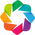

In [8]:
import geoviews as gv
import geoviews.feature as gf
import xarray as xr
from cartopy import crs

gv.extension('bokeh', 'matplotlib')

In [ ]:
dataset = gv.Dataset(sst_slice_summer_groupby)
ensemble = dataset.to(gv.Image, ['lon', 'lat'], 'sst')

gv.output(ensemble.opts(cmap='RdBu', # 'coolwarm'
                        colorbar=True, 
                        fig_size=200, 
                        backend='matplotlib') * gf.coastline(),
          backend='matplotlib')

## Anomalies calculation

In [11]:
# Anomalies will be based on 30-year climate mean period of 1991-2020 proposed by WMO  https://wmo.int/media/news/updated-30-year-reference-period-reflects-changing-climate

clim_start = 1991
clim_end = 2020

# Select Data from 1991 to 2020 from main dataset for the North Atlantic
ref_period = sst_slice.sel(time=slice(f'{clim_start}-01-01', f'{clim_end}-12-01'))
# Group by seasons
clim_groupby = ref_period.resample(time='QS-DEC').sum('time')
# Make an average for each season over 30 years
clim_groupby = clim_groupby.groupby('time.month').mean('time')
clim_groupby

<xarray.Dataset> Size: 41kB
Dimensions:  (month: 4, lat: 45, lon: 56)
Coordinates:
  * lat      (lat) float32 180B 88.0 86.0 84.0 82.0 80.0 ... 8.0 6.0 4.0 2.0 0.0
  * lon      (lon) float32 224B -98.0 -96.0 -94.0 -92.0 ... 6.0 8.0 10.0 12.0
  * month    (month) int64 32B 3 6 9 12
Data variables:
    sst      (month, lat, lon) float32 40kB -5.4 -5.4 -5.4 ... 82.3 82.09 0.0

In [12]:
# Anomalies

sst_anom_winter = sst_slice_winter_groupby - clim_groupby.sel(month=12)  # month=12 is DJF season
sst_anom_summer = sst_slice_summer_groupby - clim_groupby.sel(month=6)   # month=6 is JJA season
sst_anom_summer

<xarray.Dataset> Size: 2MB
Dimensions:  (lat: 45, lon: 56, time: 171)
Coordinates:
  * lat      (lat) float32 180B 88.0 86.0 84.0 82.0 80.0 ... 8.0 6.0 4.0 2.0 0.0
  * lon      (lon) float32 224B -98.0 -96.0 -94.0 -92.0 ... 6.0 8.0 10.0 12.0
  * time     (time) datetime64[ns] 1kB 1854-06-01 1855-06-01 ... 2024-06-01
    month    int64 8B 6
Data variables:
    sst      (time, lat, lon) float32 2MB 3.6 3.6 3.6 3.6 ... -50.03 -49.82 nan

In [35]:
# Save anomalies (id needed)

sst_anom_winter.to_netcdf('/home/jovyan/ohw24_proj_north_atlantic_variability_us/contributor_folders/Tanya_Popova/sstA_winter.nc')
sst_anom_summer.to_netcdf('/home/jovyan/ohw24_proj_north_atlantic_variability_us/contributor_folders/Tanya_Popova/sstA_summer.nc')

## Make plots for each year to combine into .gif

In [13]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

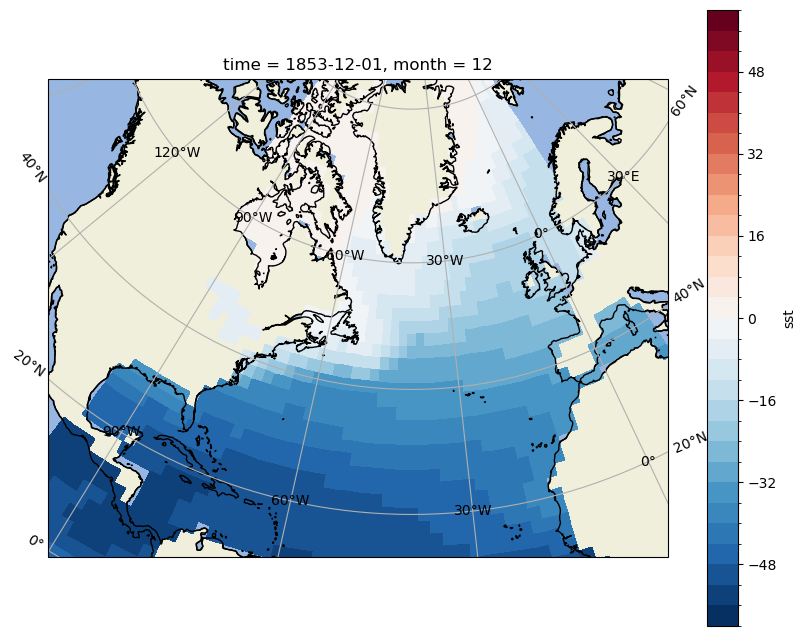

In [17]:
data = sst_anom_winter.sst.isel(time=0)
fig = plt.figure(figsize=(10, 8))
    
# Define the projection: North Atlantic view (Lambert Conformal Projection)
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-40, central_latitude=50))

# Set extent: North Atlantic region
ax.set_extent([-99, 0, 13, 80], crs=ccrs.PlateCarree())

# Add coastlines and gridlines
ax.coastlines(resolution='50m')
ax.gridlines(draw_labels=True)

# Add land and ocean features
ax.add_feature(cfeature.LAND, zorder=1, edgecolor='black')
ax.add_feature(cfeature.OCEAN, zorder=0)

# Plot the data
im = data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu_r', levels=30, add_colorbar=True)

plt.show()


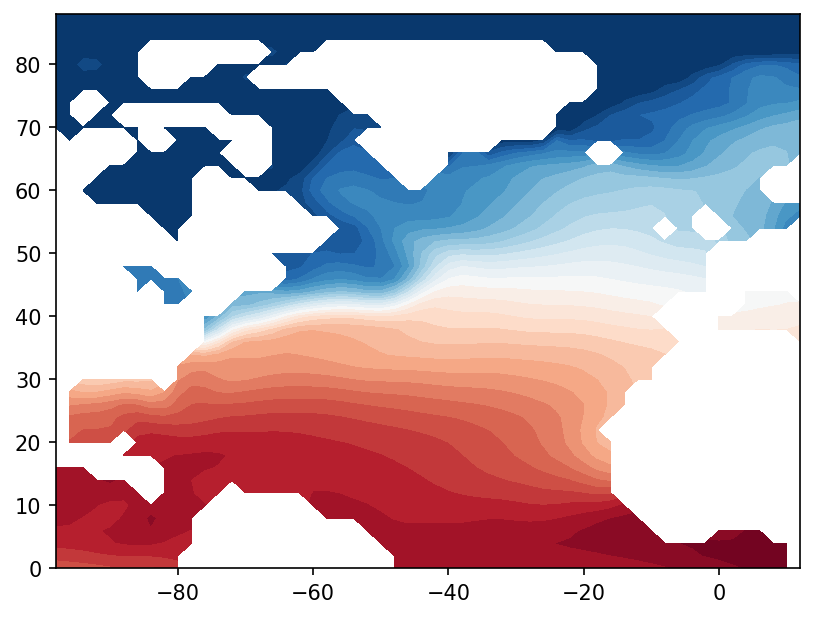

In [18]:
fig = plt.figure(dpi=150)
plt.contourf(sst_anom_winter.lon, 
            sst_anom_winter.lat,
            sst_anom_winter.sst.isel(time=0).values,
            levels=30,
            cmap='RdBu')
plt.show()